In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols, adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AR,ARResults
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse,rmse




%matplotlib inline

In [7]:
df = pd.read_csv('arima_eda.csv')

In [8]:
df.set_index('Date1', inplace=True) 
df.index=pd.to_datetime(df.index)

In [9]:
df.head()

,PowerA,PowerB,AirFlow_Zone4,dissolved02_All,dissolved02,Hour,Day
Date1,,,,,,,
2019-08-13 16:00:00,1.034467e+06,483884.59070,3512.446118,1.663969,1.479520,16,Tue
2019-08-13 20:00:00,1.232730e+06,489331.77670,3528.054032,1.546575,1.511921,20,Tue
2019-08-14 00:00:00,1.020047e+06,378832.87310,3862.125437,1.958906,1.850203,0,Wed
2019-08-14 04:00:00,9.212818e+05,31880.01050,3915.824151,2.249302,2.286969,4,Wed
2019-08-14 08:00:00,1.214494e+06,66504.77959,3633.866031,1.902027,1.926427,8,Wed


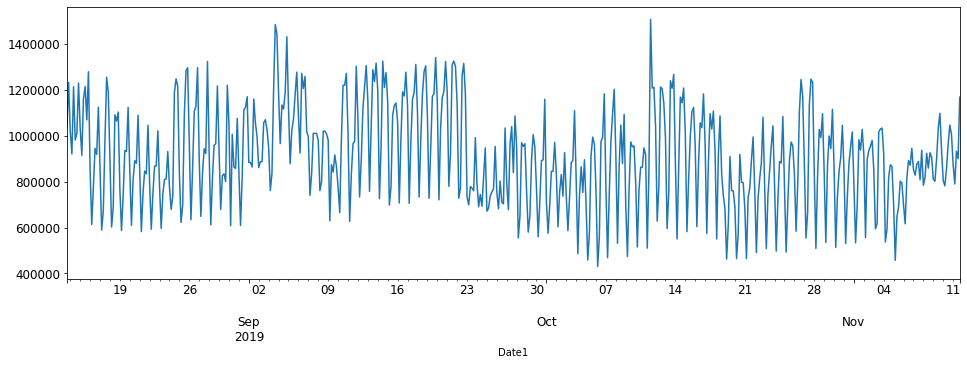

In [11]:
#Visual of power source A power usage 
df['PowerA'].plot(figsize=(16,5), fontsize=12);

In [12]:
# Creating a new DF for Power A for some additional Analysis 
df_a = pd.DataFrame(index=df.index, columns= ('PowerA', 'Hour'))
df_a['PowerA'] = df['PowerA']
df_a['Hour'] = df['Hour']
df_a.index.freq = '4H'

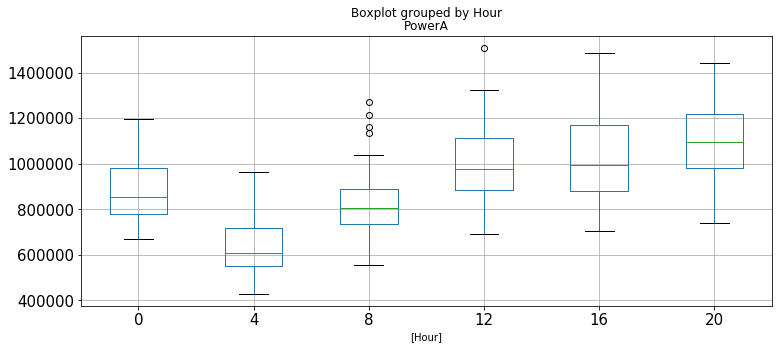

In [13]:
# Hourly Power Consumption grouped by hour 
# Can see a clear trend 4 A.M. lowest usage and 8 P.M. Highest usage 
df_a.boxplot(by='Hour',figsize=(12,5), fontsize=15);

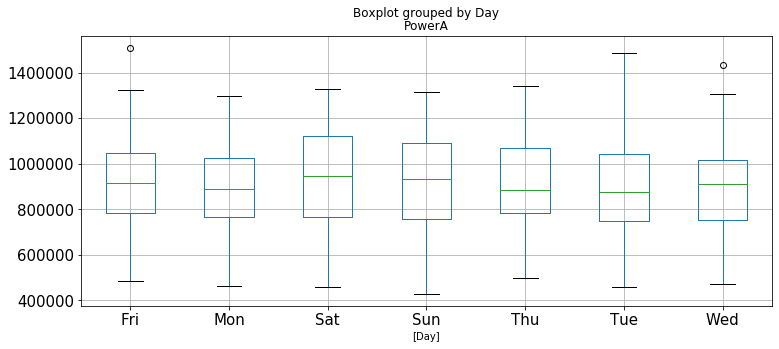

In [14]:
#No real clear trend.  Would probably need more data to determine if there is a difference 
df_a_day = pd.DataFrame(index=df.index)
df_a_day['PowerA'] = df['PowerA']
df_a_day['Day'] = df['Day']
df_a_day.boxplot(by='Day',figsize=(12,5), fontsize=15);

## ETS Decomposition 

In [15]:
df.head()

,PowerA,PowerB,AirFlow_Zone4,dissolved02_All,dissolved02,Hour,Day
Date1,,,,,,,
2019-08-13 16:00:00,1.034467e+06,483884.59070,3512.446118,1.663969,1.479520,16,Tue
2019-08-13 20:00:00,1.232730e+06,489331.77670,3528.054032,1.546575,1.511921,20,Tue
2019-08-14 00:00:00,1.020047e+06,378832.87310,3862.125437,1.958906,1.850203,0,Wed
2019-08-14 04:00:00,9.212818e+05,31880.01050,3915.824151,2.249302,2.286969,4,Wed
2019-08-14 08:00:00,1.214494e+06,66504.77959,3633.866031,1.902027,1.926427,8,Wed


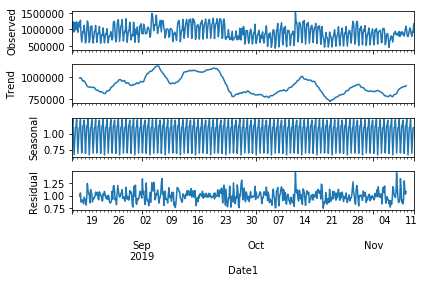

In [16]:
power_a_result = seasonal_decompose(df['PowerA'], model='multiplicative') 
power_a_result.plot();
#Trend - Genearl Pattern Overtime.  September highest Usage 
#Seasonal - Daily Cycles
# Residual - Any data not explained by the Trend or Seasonality

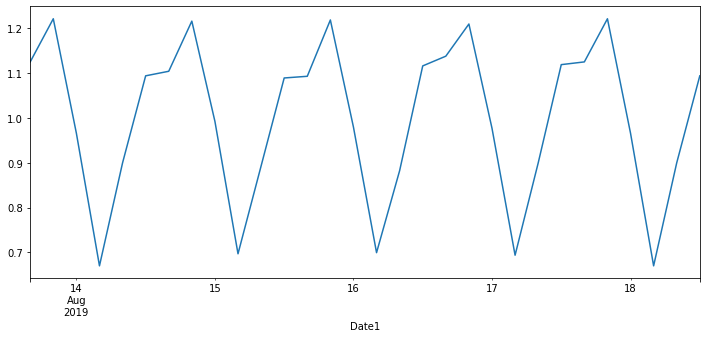

In [17]:
# Zoomed in  on the seasonal portion and can clearly see that there is daily seasonality.  
ax, fig = ig, ax = plt.subplots(figsize=(12,5))
power_a_result.seasonal[:30].plot()

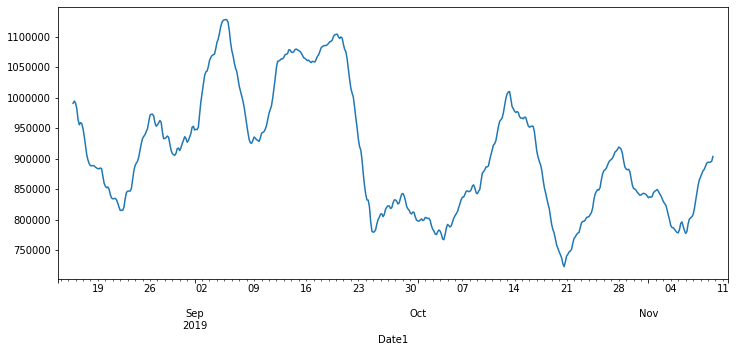

In [18]:
power_a_result.trend.plot(figsize=(12,5))

## Forecast Modeling - Exponential Smoothing 
### Holt-Winters

In [19]:
train_data = df_a.iloc[:529]
test_data = df_a.iloc[529:]
train_data = train_data.astype('double')

# Fits the Train Data to the Exponential Smoothing Model
fitted_model = ExponentialSmoothing(train_data['PowerA'],trend='mul',seasonal='mul',seasonal_periods=6).fit()

# Fits the Test Predictions
test_predictions = fitted_model.forecast(12).rename('Holt-Winters Forecast')

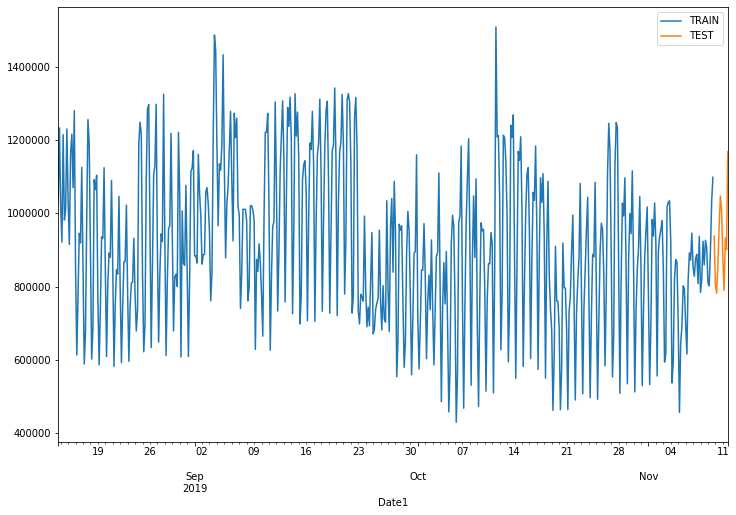

In [20]:
# Forecasts two days into the future using exponential smoothing 
train_data['PowerA'].plot(legend=True,label='TRAIN')
test_data['PowerA'].plot(legend=True,label='TEST',figsize=(12,8));

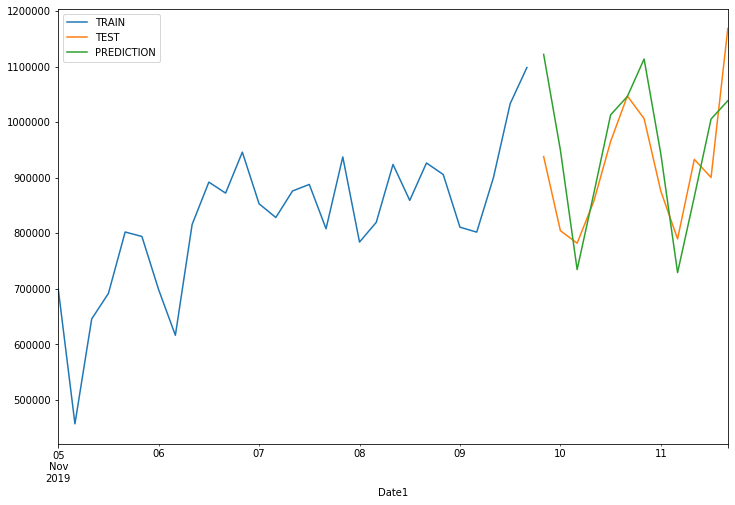

In [21]:
# Prediction 
train_data['PowerA'][500:].plot(legend=True,label='TRAIN')
test_data['PowerA'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluating Results:
Not the Best Model. Predicting Two days into the future will give a general idea of the trend, but there is still a wide margin of error.

## Autocorrelation / Partial Autocorrelation Functions

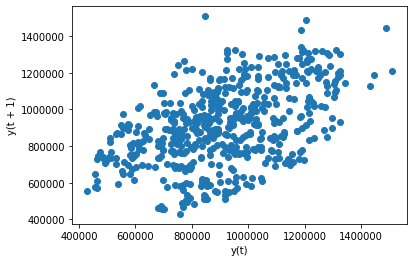

In [22]:
# Slight Positive Correlation
lag_plot(df_a['PowerA']);

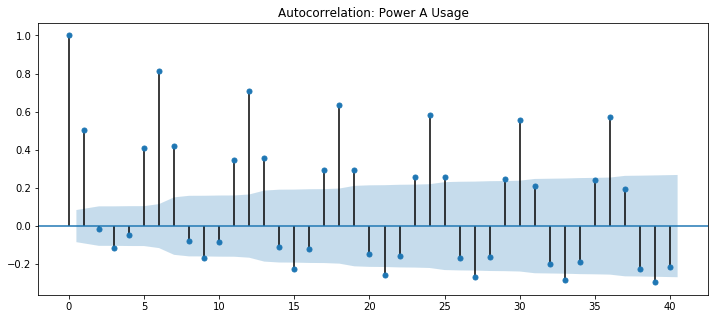

In [23]:
# Can see that every 6th lag has a high correlation.  This makes sense since the daily cycles repeat every 6 
# Data points 
title = 'Autocorrelation: Power A Usage'
lags = 40
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df_a['PowerA'],title=title,lags=lags, ax=ax);

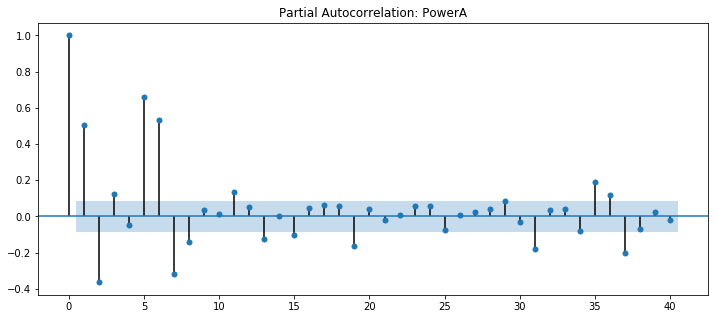

In [24]:
# Drops off a lot faster which is expected 
title='Partial Autocorrelation: PowerA'
lags=40
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df_a['PowerA'],title=title,lags=lags, ax=ax);

## Auto Regression
Below Code is using a AR lag of 1.  This portion of purely an exploritory step inorder to find the best AR Lag for this data.   

In [25]:
train_data = df_a.iloc[:529]
test_data = df_a.iloc[529:]

model = AR(train_data['PowerA'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')



Lag: 1
Coefficients:
const        448650.355324
L1.PowerA         0.507434
dtype: float64


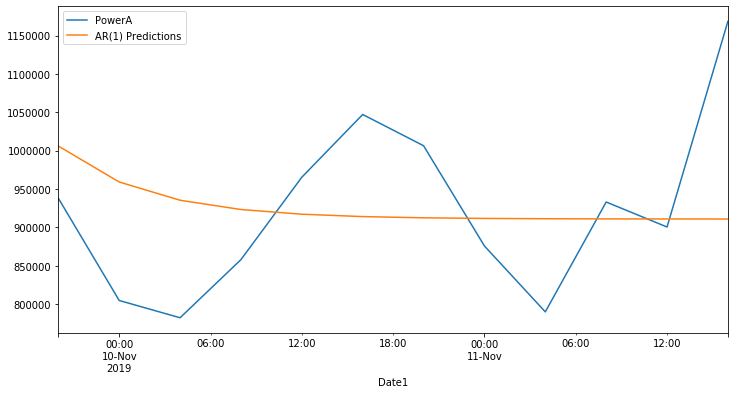

In [26]:
# Not a very good prediction.  Way to smooth for the model 
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

### AR maxlag order of 2

Lag: 2
Coefficients:
const        613042.013524
L1.PowerA         0.691050
L2.PowerA        -0.364610
dtype: float64


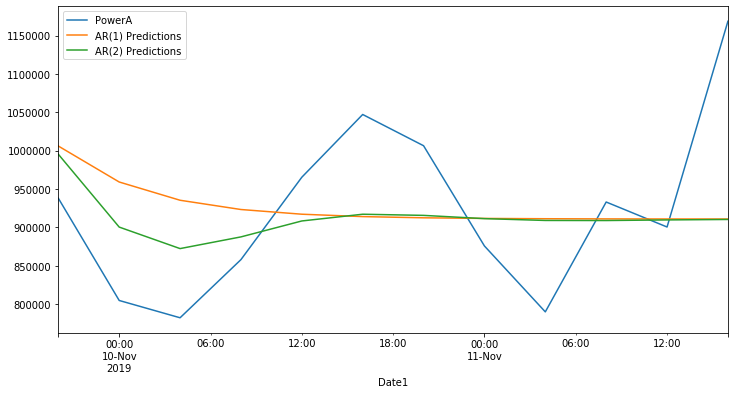

In [27]:
# Autoregression lag of 2 fits the model a little better, but still to smooth overall 
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

### Graphing out Auto Regression Lags 3 - 10 to see how the predictions improve 

Lag: 3
Coefficients:
const        532701.237001
L1.PowerA         0.738950
L2.PowerA        -0.454618
L3.PowerA         0.130463
dtype: float64


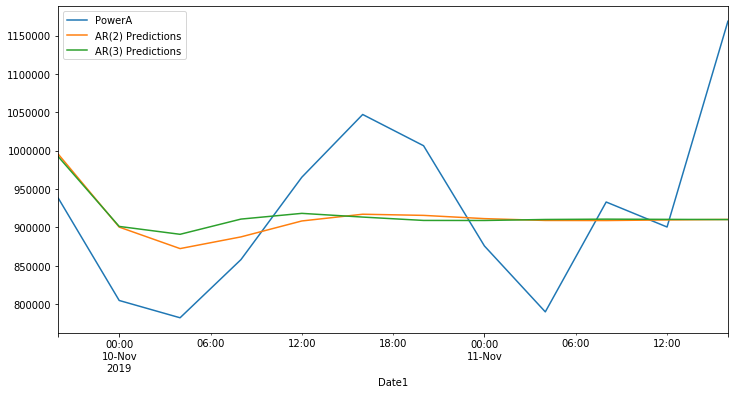

In [28]:
AR2fit = model.fit(maxlag=3,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions3 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(3) Predictions')
test_data['PowerA'].plot(legend=True)
predictions2.plot(legend=True)
predictions3.plot(legend=True,figsize=(12,6));

Lag: 4
Coefficients:
const        562007.811867
L1.PowerA         0.745675
L2.PowerA        -0.479188
L3.PowerA         0.169964
L4.PowerA        -0.053879
dtype: float64


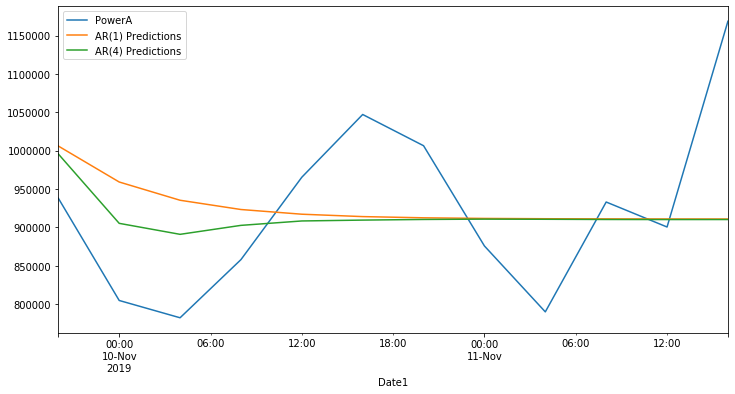

In [29]:
AR2fit = model.fit(maxlag=4,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(4) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 5
Coefficients:
const        193260.901240
L1.PowerA         0.779205
L2.PowerA        -0.589272
L3.PowerA         0.485780
L4.PowerA        -0.547803
L5.PowerA         0.660737
dtype: float64


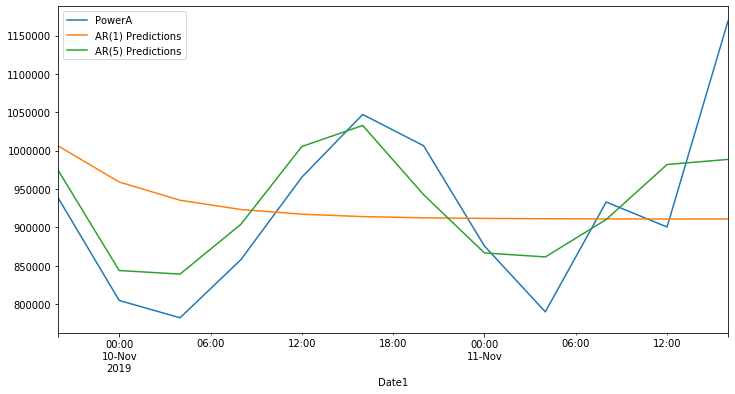

In [30]:
AR2fit = model.fit(maxlag=5,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(5) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 6
Coefficients:
const        96124.660628
L1.PowerA        0.438619
L2.PowerA       -0.308799
L3.PowerA        0.237591
L4.PowerA       -0.243837
L5.PowerA        0.259952
L6.PowerA        0.512203
dtype: float64


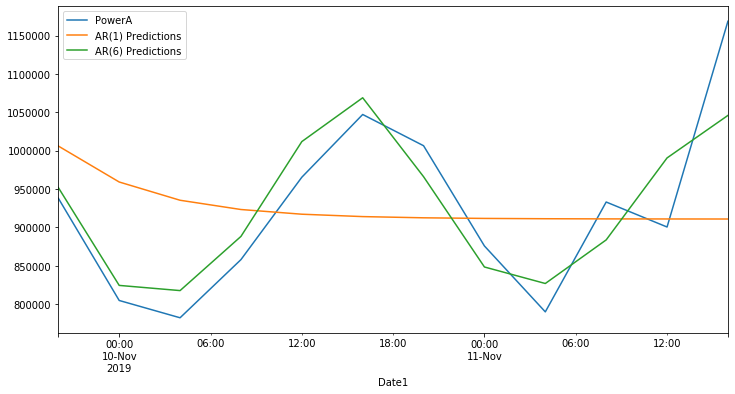

In [31]:
AR2fit = model.fit(maxlag=6,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(6) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 7
Coefficients:
const        124619.763009
L1.PowerA         0.605664
L2.PowerA        -0.224233
L3.PowerA         0.159252
L4.PowerA        -0.168373
L5.PowerA         0.159641
L6.PowerA         0.654617
L7.PowerA        -0.322474
dtype: float64


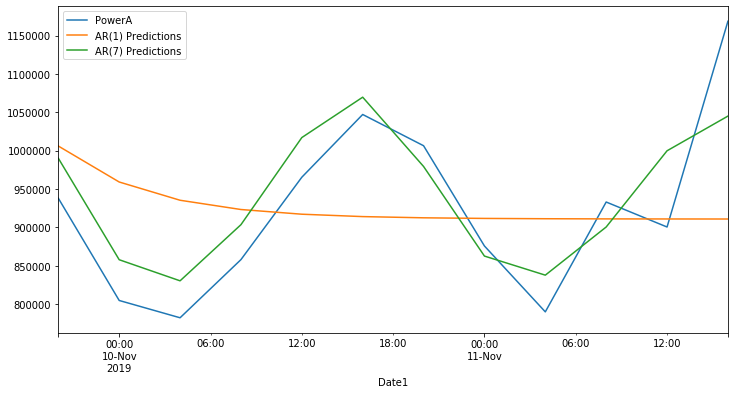

In [32]:
AR2fit = model.fit(maxlag=7,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(7) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 8
Coefficients:
const        139559.913299
L1.PowerA         0.566605
L2.PowerA        -0.144611
L3.PowerA         0.178612
L4.PowerA        -0.188354
L5.PowerA         0.178082
L6.PowerA         0.627355
L7.PowerA        -0.249372
L8.PowerA        -0.120707
dtype: float64


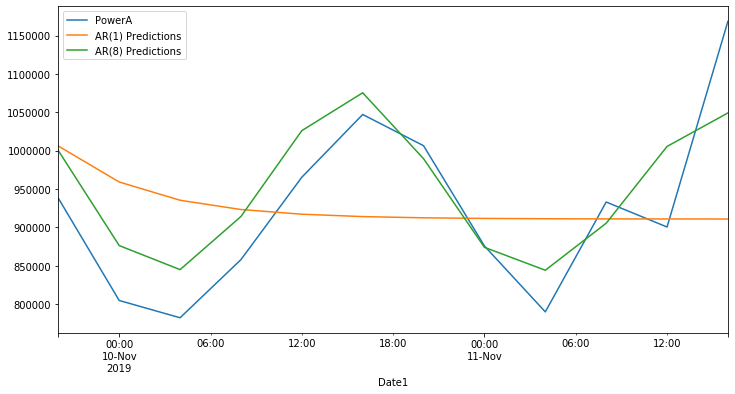

In [33]:
AR2fit = model.fit(maxlag=8,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(8) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

Lag: 9
Coefficients:
const        134646.173073
L1.PowerA         0.571425
L2.PowerA        -0.134589
L3.PowerA         0.153301
L4.PowerA        -0.195677
L5.PowerA         0.185406
L6.PowerA         0.620367
L7.PowerA        -0.243592
L8.PowerA        -0.143460
L9.PowerA         0.039866
dtype: float64


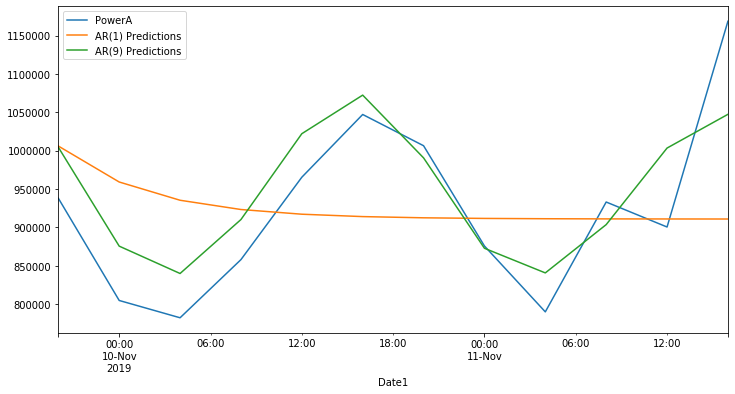

In [34]:
AR2fit = model.fit(maxlag=9,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(9) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

/Users/eric/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Lag: 10
Coefficients:
const         133672.663487
L1.PowerA          0.571340
L2.PowerA         -0.133957
L3.PowerA          0.154337
L4.PowerA         -0.198219
L5.PowerA          0.184709
L6.PowerA          0.621231
L7.PowerA         -0.244185
L8.PowerA         -0.142871
L9.PowerA          0.037574
L10.PowerA         0.004155
dtype: float64


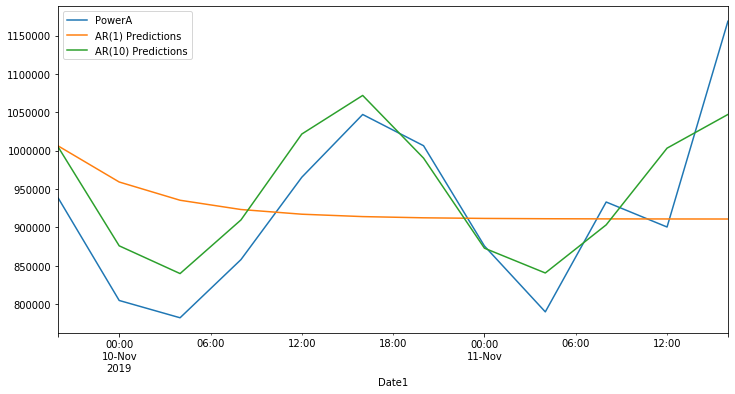

In [35]:
AR2fit = model.fit(maxlag=10,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(10) Predictions')
test_data['PowerA'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

#### As expected in this portion a lag of around 6 is where the prediction using AR starts to really become significant.  This makes sense because a cycle is every 6 data points or 24 hours. 

## Choosing SARIMAX ORDERS
Grid Search



In [36]:
#Based on the Summary Below the best Sarimax model is SARIMAX(5, 1, 1)x(2, 0, 2, 6)
# Auto REgression Lagging 5
# Moving Average Lagging 1


powera_fit = auto_arima(df_a['PowerA'], start_p=5, start_q=0,
                          max_p=25, max_q=3, m=6,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)  

powera_fit.summary()

Fit ARIMA: order=(5, 1, 0) seasonal_order=(1, 0, 1, 6); AIC=14038.364, BIC=14076.988, Fit time=0.658 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 6); AIC=14775.448, BIC=14784.031, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 6); AIC=14432.655, BIC=14449.821, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 6); AIC=14549.074, BIC=14566.241, Fit time=0.085 seconds
Fit ARIMA: order=(5, 1, 0) seasonal_order=(0, 0, 1, 6); AIC=14136.584, BIC=14170.917, Fit time=0.298 seconds
Fit ARIMA: order=(5, 1, 0) seasonal_order=(2, 0, 1, 6); AIC=14040.019, BIC=14082.934, Fit time=0.971 seconds
Fit ARIMA: order=(5, 1, 0) seasonal_order=(1, 0, 0, 6); AIC=14136.561, BIC=14170.894, Fit time=0.784 seconds
Fit ARIMA: order=(5, 1, 0) seasonal_order=(1, 0, 2, 6); AIC=14039.483, BIC=14082.399, Fit time=0.729 seconds
Fit ARIMA: order=(5, 1, 0) seasonal_order=(0, 0, 0, 6); AIC=14135.383, BIC=14165.424, Fit time=0.217 seconds
Fit ARIMA: order=(5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  541
Model:             SARIMAX(5, 1, 1)x(2, 0, 2, 6)   Log Likelihood               -7005.900
Date:                           Tue, 17 Dec 2019   AIC                          14035.799
Time:                                   13:29:53   BIC                          14087.298
Sample:                                        0   HQIC                         14055.940
                                           - 541                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -770.8114    712.151     -1.082      0.279   -2166.602     624.979
ar.L1         -0.5219      0.116     -4.517      0.000      -0.748      -0.295
ar.L2         -0.5307      0.058     -9.180      0.000      -0.644      -0.417
ar.L3         -0.3873      0.067     -5.796      0.000      -0.518      -0.256
ar.L4         -0.4042      0.045     -9.039      0.000      -0.492      -0.317
ar.L5         -0.3927      0.050     -7.839      0.000      -0.491      -0.295
ma.L1          0.1521      0.128      1.184      0.236      -0.100       0.404
ar.S.L6        0.0122      0.063      0.194      0.847      -0.111       0.136
ar.S.L12       0.9676      0.061     15.890      0.000       0.848       1.087
ma.S.L6        0.0693      0.085      0.819      0.413      -0.097       0.235
ma.S.L12      -0.9156      0.072    -12.710      0.000      -1.057      -0.774
sigma2      1.185e+10      0.000   9.15e+13      0.000    1.18e+10    1.18e+10
===================================================================================
Ljung-Box (Q):                       48.74   Jarque-Bera (JB):               170.36
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+29. Standard errors may be unstable.
"""

In [37]:
# Running Auto Arima once more without params 
powera_sarimax_fit = auto_arima(df_a['PowerA'], seasonal=True, m=6)

/Users/eric/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/eric/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/eric/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/eric/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/eric/anaconda3/lib/python3.7/

In [38]:
powera_sarimax_fit.summary()
#Based on the Summary Below the best Sarimax model is SARIMAX(2, 1, 2)x(1, 0, 2, 6)
# Auto REgression Lagging 2
# Moving Average Lagging 2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  541
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 6)   Log Likelihood               -7095.627
Date:                           Tue, 17 Dec 2019   AIC                          14209.254
Time:                                   13:31:52   BIC                          14247.878
Sample:                                        0   HQIC                         14224.360
                                           - 541                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -759.1472    902.248     -0.841      0.400   -2527.521    1009.227
ar.L1         -0.4129      0.195     -2.123      0.034      -0.794      -0.032
ar.L2          0.3038      0.169      1.799      0.072      -0.027       0.635
ma.L1          0.0469      0.152      0.310      0.757      -0.250       0.344
ma.L2         -0.7533      0.143     -5.263      0.000      -1.034      -0.473
ar.S.L6        0.9651      0.028     34.852      0.000       0.911       1.019
ma.S.L6       -0.5015      0.100     -5.021      0.000      -0.697      -0.306
ma.S.L12      -0.2481      0.105     -2.352      0.019      -0.455      -0.041
sigma2      2.678e+10   9.68e-05   2.77e+14      0.000    2.68e+10    2.68e+10
===================================================================================
Ljung-Box (Q):                       71.19   Jarque-Bera (JB):               193.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.51e+29. Standard errors may be unstable.
"""

## Sarimax Model 

In [39]:
train_data = df_a.iloc[:529]
test_data = df_a.iloc[529:]

In [40]:
model = SARIMAX(train_data['PowerA'],order=(2, 1, 2),seasonal_order=(1, 0, 2, 6))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            PowerA   No. Observations:                  529
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 6)   Log Likelihood               -6937.162
Date:                           Tue, 17 Dec 2019   AIC                          13890.325
Time:                                   13:34:49   BIC                          13924.477
Sample:                               08-13-2019   HQIC                         13903.695
                                    - 11-09-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2368      0.242     -0.978      0.328      -0.711       0.238
ar.L2          0.4652      0.201      2.316      0.021       0.072       0.859
ma.L1         -0.1166      0.199     -0.587      0.557      -0.506       0.273
ma.L2         -0.8782      0.204     -4.295      0.000      -1.279      -0.477
ar.S.L6        0.9798      0.022     45.307      0.000       0.937       1.022
ma.S.L6       -0.5183      0.103     -5.040      0.000      -0.720      -0.317
ma.S.L12      -0.3052      0.105     -2.911      0.004      -0.511      -0.100
sigma2      2.727e+10   8.86e-12   3.08e+21      0.000    2.73e+10    2.73e+10
===================================================================================
Ljung-Box (Q):                       79.34   Jarque-Bera (JB):               171.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+37. Standard errors may be unstable.
"""

In [41]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(2, 1, 2)x(1, 0, 2, 6) Predictions')

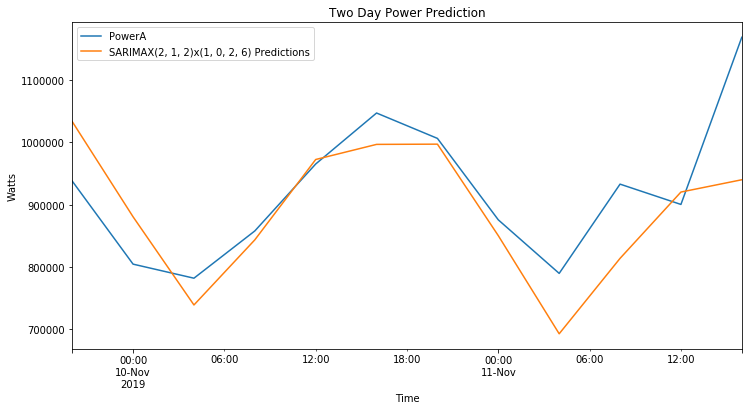

In [42]:
# Plot predictions against known values

title = 'Two Day Power Prediction'
ylabel='Watts'
xlabel='Time'

ax = test_data['PowerA'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);